# Purpose
This notebook is meant to be a high-level EDA to check posts counts for subs that have been identified as relevant to Germany. 
[TODO: comments in a separate notebook]

I will use these high-level counts to select posts & comments for text selection for topic modeling.

# Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from google.cloud import storage
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px

import subclu
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array
)
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.eda.aggregates import (
    compare_raw_v_weighted_language,
    get_language_by_sub_wide,
    get_language_by_sub_long,
)
from subclu.data.data_loaders import LoadSubreddits, LoadPosts, LoadComments

from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)


print_lib_versions([np, pd, sns, plotly, subclu])

python		v 3.7.10
===
numpy		v: 1.18.5
pandas		v: 1.2.5
seaborn		v: 0.11.1
plotly		v: 4.14.3
subclu		v: 0.4.0


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()


# Load config with data

In [4]:
config_data_v040 = LoadHydraConfig(
    config_path="../config/data_text_and_metadata",
    config_name='v0.4.0_19k_top_subs_and_geo_relevant_2021_09_27',
#     config_name='top_subreddits_2021_07_16',
)

# config_seeds = LoadHydraConfig(
#     config_name='seed_counterparts_germany_2021-08-17',
#     config_path="../config/data_subreddit_counterparts",
# )

# pprint(config_data_v040.config_dict, indent=2)
# pprint(config_seeds.config_dict)
config_data_v040.config_dict

{'dataset_name': 'v0.4.0 inputs - Top Subreddits (no Geo) + Geo-relevant subs, comments: TBD',
 'bucket_name': 'i18n-subreddit-clustering',
 'folder_subreddits_text_and_meta': 'subreddits/top/2021-09-24',
 'folder_posts_text_and_meta': 'posts/top/2021-09-27',
 'folder_comments_text_and_meta': None}

# Load posts

Use data loader class because it standardizes transformations and data quality checks.

In [5]:
%%time

df_posts = LoadPosts(
    bucket_name=config_data_v040.config_dict['bucket_name'],
    folder_path=config_data_v040.config_dict['folder_posts_text_and_meta'],
    columns=None,
    col_new_manual_topic='manual_topic_and_rating',
    col_unique_check='post_id',
).read_and_apply_transformations()

16:59:38 | INFO | "Reading raw data..."
16:59:39 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-09-27"


  0%|          | 0/27 [00:00<?, ?it/s]

17:00:02 | INFO | "  Applying transformations..."


CPU times: user 1min 4s, sys: 14 s, total: 1min 18s
Wall time: 59.3 s


In [6]:
df_posts.shape

(8439672, 51)

In [7]:
df_posts.iloc[:5, :15]

,rank_post_in_sub,subreddit_name,subreddit_id,post_id,user_id,thing_type,submit_date,removed,upvotes,upvotes_lookup,downvotes_lookup,net_upvotes_lookup,neutered,verdict,content_category
0,199,circumcisiongrief,t5_zzszh,t3_oy5757,t2_cdn9ircp,post,2021-08-04,0,0,1,2,-1,False,None,None
1,198,circumcisiongrief,t5_zzszh,t3_p7959y,t2_7z7fqqtm,post,2021-08-19,0,0,1,1,0,False,None,None
2,197,circumcisiongrief,t5_zzszh,t3_p9qjt4,t2_8rcku5uw,post,2021-08-23,0,0,1,1,0,False,None,None
3,196,circumcisiongrief,t5_zzszh,t3_p6pby5,t2_2uz4eeg1,post,2021-08-18,0,0,1,0,1,False,None,None
4,195,circumcisiongrief,t5_zzszh,t3_p01h3v,t2_deglsbh4,post,2021-08-07,0,0,1,0,1,False,mod-approved,None


# Load subreddit meta

With meta + posts we can get some additional data to get subreddit-level aggregates


In [9]:
%%time
df_sub_meta = LoadSubreddits(
    bucket_name=config_data_v040.config_dict['bucket_name'],
    folder_path=config_data_v040.config_dict['folder_subreddits_text_and_meta'],
    folder_posts=None,
    columns=None,
).read_apply_transformations_and_merge_post_aggs(df_posts=df_posts)

15:11:05 | INFO | "  reading sub-level data & merging with aggregates..."
15:11:05 | INFO | "Reading raw data..."
15:11:05 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-09-24"


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:06 | INFO | "  Applying transformations..."


CPU times: user 9.93 s, sys: 2.87 s, total: 12.8 s
Wall time: 13.4 s


In [10]:
df_sub_meta.shape

(19262, 91)

In [11]:
df_sub_meta[df_sub_meta['geo_relevant_subreddit'] == True].iloc[:10, :15]

,pt_date,subreddit_name,subreddit_id,geo_relevant_country_codes,geo_relevant_countries,geo_relevant_country_count,geo_relevant_subreddit,ambassador_subreddit,combined_topic,combined_topic_and_rating,rating_short,rating_name,primary_topic,secondary_topics,mature_themes_list
102,2021-09-21,askuk,t5_2t4s3,GB,United Kingdom,1.0,True,False,uncategorized,uncategorized,E,Everyone,Place,,
103,2021-09-21,casualuk,t5_3j2jr,GB,United Kingdom,1.0,True,False,uncategorized,uncategorized,E,Everyone,None,,
126,2021-09-21,soccer,t5_2qi58,GB,United Kingdom,1.0,True,False,uncategorized,uncategorized,E,Everyone,Sports,,
161,2021-09-21,canada,t5_2qh68,CA,Canada,1.0,True,False,uncategorized,uncategorized,E,Everyone,Place,,
174,2021-09-21,australia,t5_2qh8e,AU,Australia,1.0,True,False,uncategorized,uncategorized,E,Everyone,Place,,"profanity_occasional, profanity"
187,2021-09-21,ontario,t5_2qsf3,CA,Canada,1.0,True,False,uncategorized,uncategorized,E,Everyone,Place,,
204,2021-09-21,britishproblems,t5_2sumw,GB,United Kingdom,1.0,True,False,uncategorized,uncategorized,E,Everyone,Funny/Humor,,"profanity_occasional, profanity"
224,2021-09-21,de,t5_22i0,DE,Germany,1.0,True,False,uncategorized,uncategorized,E,Everyone,Place,,
241,2021-09-21,ksi,t5_2xd5g,GB,United Kingdom,1.0,True,False,uncategorized,uncategorized,E,Everyone,Funny/Humor,,
261,2021-09-21,unitedkingdom,t5_2qhqb,GB,United Kingdom,1.0,True,False,uncategorized,uncategorized,E,Everyone,Place,,


In [12]:
df_sub_meta[df_sub_meta['geo_relevant_subreddit'] == True].iloc[-10:, :15]

,pt_date,subreddit_name,subreddit_id,geo_relevant_country_codes,geo_relevant_countries,geo_relevant_country_count,geo_relevant_subreddit,ambassador_subreddit,combined_topic,combined_topic_and_rating,rating_short,rating_name,primary_topic,secondary_topics,mature_themes_list
19194,2021-09-21,aguascalientesmx,t5_52et5h,MX,Mexico,1.0,True,False,uncategorized,uncategorized,None,None,None,None,None
19195,2021-09-21,southindiangirls,t5_52fqtg,IN,India,1.0,True,False,uncategorized,uncategorized,None,None,None,None,None
19196,2021-09-21,antisensetherapeutics,t5_50wjrp,DE,Germany,1.0,True,False,uncategorized,uncategorized,None,None,None,None,None
19197,2021-09-21,criptoportugal,t5_50hito,PT,Portugal,1.0,True,False,uncategorized,uncategorized,None,None,None,,
19199,2021-09-21,iphone12walls,t5_51fixo,IN,India,1.0,True,False,uncategorized,uncategorized,None,None,None,None,None
19201,2021-09-21,shittyshitcoinsnft,t5_51d131,ES,Spain,1.0,True,False,uncategorized,uncategorized,None,None,None,,
19203,2021-09-21,sport_candy,t5_51twc4,IN,India,1.0,True,False,uncategorized,uncategorized,None,None,None,None,None
19207,2021-09-21,gangelias,t5_51y9yj,DE,Germany,1.0,True,False,uncategorized,uncategorized,None,None,None,,
19208,2021-09-21,indiaisgreatnews,t5_51swhj,IN,India,1.0,True,False,uncategorized,uncategorized,None,None,None,,
19212,2021-09-21,artficer,t5_526cq6,BR,Brazil,1.0,True,False,uncategorized,uncategorized,None,None,None,None,None


# Post-level EDA

In [13]:
%%time
df_posts.info()  # memory_usage='deep'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439672 entries, 0 to 8439671
Data columns (total 51 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   rank_post_in_sub                       int64  
 1   subreddit_name                         object 
 2   subreddit_id                           object 
 3   post_id                                object 
 4   user_id                                object 
 5   thing_type                             object 
 6   submit_date                            object 
 7   removed                                int64  
 8   upvotes                                int64  
 9   upvotes_lookup                         int64  
 10  downvotes_lookup                       int64  
 11  net_upvotes_lookup                     int64  
 12  neutered                               bool   
 13  verdict                                object 
 14  content_category                       object 
 15

In [39]:
counts_describe(df_posts)

,dtype,count,unique,unique-percent,null-count,null-percent
rank_post_in_sub,int64,"8,439,672","1,200",0.01%,0,0.00%
subreddit_name,object,"8,439,672","19,192",0.23%,0,0.00%
subreddit_id,object,"8,439,672","19,192",0.23%,0,0.00%
post_id,object,"8,439,672","8,439,672",100.00%,0,0.00%
user_id,object,"8,439,672","3,200,521",37.92%,0,0.00%
thing_type,object,"8,439,672",1,0.00%,0,0.00%
submit_date,object,"8,439,672",52,0.00%,0,0.00%
removed,int64,"8,439,672",1,0.00%,0,0.00%
upvotes,int64,"8,439,672","26,644",0.32%,0,0.00%
upvotes_lookup,int64,"8,439,672","12,681",0.15%,0,0.00%


# Total days in dataset

In [8]:
%%time
df_posts['submit_date'] = pd.to_datetime(df_posts['submit_date'], format='%Y-%m-%d')

CPU times: user 2.05 s, sys: 404 ms, total: 2.46 s
Wall time: 2.45 s


In [9]:
df_posts['submit_date'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 8439672
unique                     52
top       2021-08-25 00:00:00
freq                   171870
first     2021-08-01 00:00:00
last      2021-09-21 00:00:00
Name: submit_date, dtype: object

In [10]:
day_range = 1 + (df_posts['submit_date'].max() - df_posts['submit_date'].min()).days
day_range

52

# High level stats

## Posts per sub


We need to use a log-scale because the difference between the subs with the most posts is orders of magnitude more than subs with fewer posts.

In [17]:
%%time
df_posts_per_sub = value_counts_and_pcts(
    df_posts,
    ['subreddit_name'],
    top_n=None,
    return_df=True,
)
df_posts_per_sub['posts_per_day_mean'] = (
    df_posts_per_sub['count'] /
    day_range
)
display(style_df_numeric(df_posts_per_sub.head(20)))

,count,percent,cumulative_percent,posts_per_day_mean
subreddit_name,,,,
redditbay_official,"1,200",0.01%,0.01%,23.08
bonehurtingjuice,"1,200",0.01%,0.03%,23.08
teachers,"1,200",0.01%,0.04%,23.08
tea,"1,200",0.01%,0.06%,23.08
paranormal,"1,200",0.01%,0.07%,23.08
tds_roblox,"1,200",0.01%,0.09%,23.08
ender3,"1,200",0.01%,0.10%,23.08
pareidolia,"1,200",0.01%,0.11%,23.08
parenting,"1,200",0.01%,0.13%,23.08


CPU times: user 876 ms, sys: 83.1 ms, total: 959 ms
Wall time: 957 ms


In [18]:
style_df_numeric(df_posts_per_sub.tail(20))

,count,percent,cumulative_percent,posts_per_day_mean
subreddit_name,,,,
barbieanni99,1,0.00%,100.00%,0.02
lacrosse_de,1,0.00%,100.00%,0.02
linuxde,1,0.00%,100.00%,0.02
transporterporn,1,0.00%,100.00%,0.02
muenzen,1,0.00%,100.00%,0.02
brest,1,0.00%,100.00%,0.02
grazimourao_,1,0.00%,100.00%,0.02
reels,1,0.00%,100.00%,0.02
riddlebook,1,0.00%,100.00%,0.02


In [19]:
style_df_numeric(
    df_posts_per_sub['count'].describe().to_frame().T
).set_caption(f"Overall stats for post-counts per subreddit")

,count,mean,std,min,25%,50%,75%,max
count,"19,192",439.75,417.24,1.00,104.00,265.00,707.00,"1,200.00"


In [ ]:
TODO: create new single column to distinguish qualification (activity, geo relevant, ambassador & combinations)

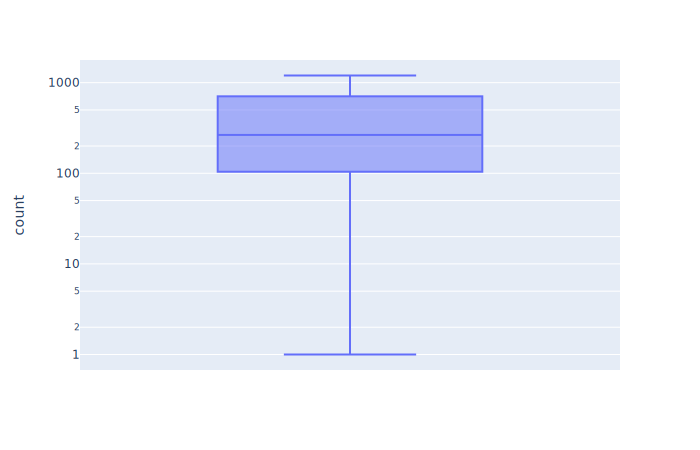

In [20]:
fig = px.box(
    df_posts_per_sub,
    y="count",
#     text='subreddit_name',
    points="outliers",
    log_y=True,
)
# fig.show()
fig.show(renderer='svg')

## Post type

Given that most of the posts are `images` or `links`, we might be limited in how much information we can get using only the text from the posts. We'll need to check how much text (length & words) each post contains.

In [21]:
value_counts_and_pcts(
    df_posts,
    ['post_type'],
    top_n=20
)

,count,percent,cumulative_percent
post_type,,,
text,"3,449,750",40.9%,40.9%
image,"2,330,712",27.6%,68.5%
link,"1,121,197",13.3%,81.8%
gallery,"607,132",7.2%,89.0%
video,"451,644",5.4%,94.3%
crosspost,"257,347",3.0%,97.4%
multi_media,"101,357",1.2%,98.6%
poll,"70,980",0.8%,99.4%
gif,"36,294",0.4%,99.8%


In [22]:
# type agg columns are now calculated in the LoadPost class:
# df_posts['post_type_grouped'] = np.where(
#     df_posts['post_type'].isin(['image', 'text', ]),
#     df_posts['post_type'],
#     'other'
# )

display(
    value_counts_and_pcts(
        df_posts,
        ['post_type_agg3'],
        top_n=5
    )
)

display(
    value_counts_and_pcts(
        df_posts,
        ['post_type_agg2'],
        top_n=5
    )
)

,count,percent,cumulative_percent
post_type_agg3,,,
text,"3,449,750",40.9%,40.9%
image,"2,330,712",27.6%,68.5%
other,"1,538,013",18.2%,86.7%
link,"1,121,197",13.3%,100.0%


,count,percent,cumulative_percent
post_type_agg2,,,
text,"3,449,750",40.9%,40.9%
other,"2,659,210",31.5%,72.4%
image,"2,330,712",27.6%,100.0%


In [23]:
style_df_numeric(
    get_language_by_sub_wide(
        df_posts,
        col_sub_name='subreddit_name',
        col_lang_weighted='post_type_agg2',
        col_total_posts='total_posts_count',
    ).head(20),
    l_bar_simple=['total_posts_count', 'image_percent', 'text_percent'],
)

,image_count,other_count,text_count,total_posts_count,image_percent,other_percent,text_percent
subreddit_name,,,,,,,
redditbay_official,41,62,"1,097","1,200",3.42%,5.17%,91.42%
bonehurtingjuice,"1,101",98,1,"1,200",91.75%,8.17%,0.08%
teachers,0,1,"1,199","1,200",0.00%,0.08%,99.92%
tea,375,294,531,"1,200",31.25%,24.50%,44.25%
paranormal,0,5,"1,195","1,200",0.00%,0.42%,99.58%
tds_roblox,879,282,39,"1,200",73.25%,23.50%,3.25%
ender3,501,560,139,"1,200",41.75%,46.67%,11.58%
pareidolia,853,347,0,"1,200",71.08%,28.92%,0.00%
parenting,0,1,"1,199","1,200",0.00%,0.08%,99.92%


## Length of post per sub - Text Length & Word Count

Even if post-type is an image, there's a chance we could get some text for topic modeling.

### Overall text length & word count

In [11]:
style_df_numeric(
    df_posts
    [['text_len', 'text_word_count']]
    .describe()
    .T
).set_caption(f"Overall Text Length Stats: Post Text Length (title + body)")

,count,mean,std,min,25%,50%,75%,max
text_len,"8,439,672",337.01,996.94,1.00,39.00,88.00,300.00,"40,286.00"
text_word_count,"8,439,672",61.34,174.17,0.00,7.00,16.00,57.00,"10,994.00"


## Len for other text
Individually:
- OCR text
- Flair text
- post_url_for_embeddings

And all of them together (so I know what's a good threshold when limiting character-len in inference job)


In [12]:
df_posts['flair_text_len'] = df_posts['flair_text'].str.len()

In [13]:
df_posts['post_url_for_embeddings_len'] = df_posts['post_url_for_embeddings'].str.len()

In [14]:
df_posts['flair_post_ocr_url_text_len'] = (
    df_posts['text_len'].fillna(0) + 
    df_posts['flair_text_len'].fillna(0) +
    df_posts['ocr_text_len'].fillna(0) +
    df_posts['post_url_for_embeddings_len'].fillna(0)
)

In [15]:
l_text_cols_raw = [c for c in df_posts.columns if 'text' in c]
l_text_cols_raw

['flair_text',
 'text_len',
 'ocr_text_len',
 'text_word_count',
 'ocr_text_word_count',
 'text',
 'ocr_inferred_text_agg_clean',
 'flair_text_len',
 'flair_post_ocr_url_text_len']

In [16]:
[c for c in df_posts.columns if 'url' in c]

['post_url',
 'post_url_for_embeddings',
 'post_url_for_embeddings_len',
 'flair_post_ocr_url_text_len']

In [17]:
%%time
df_text_len_checks =(
    df_posts
    [['flair_post_ocr_url_text_len', 'text_len', 'flair_text_len', 'ocr_text_len', 'post_url_for_embeddings_len', 'text_word_count', 'ocr_text_word_count']]
    .describe(percentiles=[.25, .5, .75, 
                           0.775, 0.8, 0.825, 0.85, 0.875, 
                           0.9, 0.925, 0.95, 0.975]
             )
    .T
    .sort_values(by=['50%', 'mean'], ascending=False)
)
df_text_len_checks.shape

CPU times: user 1.8 s, sys: 501 ms, total: 2.3 s
Wall time: 2.3 s


(7, 17)

In [18]:
style_df_numeric(
    df_text_len_checks,
    float_round=1,
    l_bar_simple=['mean', '50%', '80%', '90%'],
).set_caption(f"Overall Text Length Stats: Post Text Length (title + body)")

,count,mean,std,min,25%,50%,75%,77.5%,80%,82.5%,85%,87.5%,90%,92.5%,95%,97.5%,max
flair_post_ocr_url_text_len,"8,439,672",400.5,"1,032.2",1.0,69.0,158.0,386.0,431.0,485.0,550.0,630.0,732.0,869.0,"1,072.0","1,411.0","2,161.0","175,320.0"
ocr_text_len,"1,631,720",260.3,650.3,1.0,40.0,108.0,270.0,300.0,334.0,375.0,428.0,494.0,583.0,713.0,934.0,"1,425.0","175,296.0"
text_len,"8,439,672",337.0,996.9,1.0,39.0,88.0,300.0,346.0,400.0,464.0,543.0,642.0,776.0,968.0,"1,295.0","2,011.0","40,286.0"
post_url_for_embeddings_len,"1,214,154",55.2,42.0,1.0,23.0,45.0,77.0,81.0,86.0,91.0,96.0,102.0,108.0,116.0,126.0,144.0,"3,801.0"
ocr_text_word_count,"1,631,720",43.4,108.6,0.0,7.0,18.0,45.0,50.0,55.0,62.0,71.0,82.0,97.0,119.0,155.0,237.0,"32,060.0"
text_word_count,"8,439,672",61.3,174.2,0.0,7.0,16.0,57.0,65.0,75.0,87.0,102.0,120.0,145.0,180.0,238.0,365.0,"10,994.0"
flair_text_len,"4,236,163",10.4,6.6,0.0,6.0,9.0,13.0,13.0,14.0,15.0,16.0,17.0,18.0,20.0,23.0,27.0,64.0


### By `post_type`

In [51]:
style_df_numeric(
    df_posts
    .groupby('post_type_agg3')
    [['text_len']]
    .describe()
    .T
).set_caption(f"Text Length Stats by post_type")

In [50]:
style_df_numeric(
    df_posts
    .groupby('post_type_agg3')
    [['flair_post_ocr_url_text_len']]
    .describe(percentiles=[.25, .5, .75, 
                           0.775, 0.8, 0.825, 0.85, 0.875, 
                           0.9, 0.925, 0.95, 0.975])
    .T
).set_caption(f"Text Length Stats by post_type")

### Combine text fields into single column 

test for inference job

In [19]:
l_text_cols = ['flair_text', 'post_url_for_embeddings', 'text', 'ocr_inferred_text_agg_clean']

In [22]:
%%time
# d_mask_text = dict()

col_full_text = 'flair_post_ocr_url_text'
df_posts[col_full_text] = ''

for col_ in tqdm(l_text_cols):
    mask_c_not_null = ~df_posts[col_].isnull()
    df_posts.loc[mask_c_not_null,
                 col_full_text
                 ] = df_posts[mask_c_not_null][col_full_text] + '. ' + df_posts[mask_c_not_null][col_]

# remove the first 3 characters because they'll always be '. '
df_posts[col_full_text] = df_posts[col_full_text].str[2:]

In [32]:
df_posts[[col_full_text]].head()

,flair_post_ocr_url_text
0,Advice. 20yr old Thinking of Getting Circumcised I’m thinking of getting circumcised for two reasons. \n\n1) Improved hygiene\n2) Cosmetics/It’s the norm \n\nHaving an intact penis is an insecurity of mine. I recently got in a new relat...
1,"Advice. How can I last? My big wait is for foregen to be out, but I just don’t know how I can last 4-10 years, it’s not like I can just runaway from or ignore the trauma, because ya know, the root of the problem is on my cock. I don’t e..."
2,"Rant. Have a response, but not interested in continuing to engage, so I'll just dump it here."
3,Discussion. Difference in pleasure
4,"Grief. Do you ever feel like you've lost your chance to be normal? It's not just being cut, but a combination of everything. I grew up obese so I have gyno and loose skin, even after I lost the weight. I've had biological depression for..."


In [21]:
df_posts.loc[~df_posts['flair_text'].isnull()].shape

(4236163, 54)

### Inspect really short posts

In [65]:
(
    df_posts
    .query("flair_post_ocr_url_text_len <= 3")
    .shape
)

(14215, 54)

In [66]:
(
    df_posts
    .query("flair_post_ocr_url_text_len <= 3")
    [reorder_array(l_text_cols, 
                   df_posts.columns)
    ]
    # .drop(['subreddit_description', 'subreddit_public_description', 'subreddit_name_title_and_clean_descriptions', 'pt_date', 'pt'], axis=1)
    .sort_values(by=['text', 'subreddit_name',])
    .iloc[:10, :28]
#     ,
#     rename_cols_for_display=True,
)  # .hide_index()

,flair_text,post_url_for_embeddings,text,ocr_inferred_text_agg_clean,rank_post_in_sub,subreddit_name,subreddit_id,post_id,user_id,thing_type,submit_date,removed,upvotes,upvotes_lookup,downvotes_lookup,net_upvotes_lookup,neutered,verdict,content_category,comments,successful,app_name,post_type,post_nsfw,post_url,geolocation_country_code,combined_topic,combined_topic_and_rating
3521331,None,None,,None,26,brownbeauty,t5_2wm8d,t3_p2lwvp,t2_6odeb,post,2021-08-11,0,4,5,1,4,False,mod-approved,None,1,1,None,liveaudio,unlabeled,None,,uncategorized,uncategorized
7664945,None,None,,None,622,lgbt,t5_2qhh7,t3_p38s4u,t2_16765e,post,2021-08-12,0,47,82,3,79,False,None,None,31,1,None,liveaudio,unlabeled,None,,uncategorized,uncategorized
7826678,None,None,,None,135,podcasts,t5_2qh1d,t3_p2hq5i,t2_f0c4k,post,2021-08-11,0,20,20,7,13,False,mod-approved,None,2,1,None,liveaudio,unlabeled,None,,uncategorized,uncategorized
7853123,None,None,,None,395,readwithme,t5_2q0682,t3_oy25x4,t2_17bz64,post,2021-08-04,0,0,1,0,1,False,None,None,0,0,None,liveaudio,unlabeled,None,,"reading, writing, and literature","reading, writing, and literature"
7853416,None,None,,None,102,readwithme,t5_2q0682,t3_oy5lke,t2_17bz64,post,2021-08-04,0,19,22,0,22,False,mod-approved,None,6,1,None,liveaudio,unlabeled,None,,"reading, writing, and literature","reading, writing, and literature"
7518498,None,None,,None,998,stories,t5_2qi02,t3_papf6j,t2_qhi8i,post,2021-08-24,0,0,1,0,1,False,None,None,0,0,None,liveaudio,unlabeled,None,,uncategorized,uncategorized
7518983,None,None,,None,513,stories,t5_2qi02,t3_papmyo,t2_qhi8i,post,2021-08-24,0,2,3,0,3,False,None,None,0,0,None,liveaudio,unlabeled,None,,uncategorized,uncategorized
7519388,None,None,,None,108,stories,t5_2qi02,t3_pazg7p,t2_qhi8i,post,2021-08-24,0,27,31,2,29,False,None,None,4,1,None,liveaudio,unlabeled,None,,uncategorized,uncategorized
2146376,None,None,,None,371,toastme,t5_39em5,t3_p1s1ho,t2_1u6tsi7c,post,2021-08-10,0,17,21,0,21,False,mod-approved,None,7,1,None,liveaudio,unlabeled,None,,uncategorized,uncategorized
5176772,None,None,,None,48,truegaming,t5_2sgq6,t3_p7plzn,t2_12hz4a,post,2021-08-19,0,209,233,22,211,False,mod-approved,None,15,1,None,liveaudio,unlabeled,None,,uncategorized,uncategorized


In [67]:
(
    df_posts
    .query("flair_post_ocr_url_text_len <= 3")
    [reorder_array(l_text_cols, 
                   df_posts.columns)
    ]
    # .drop(['subreddit_description', 'subreddit_public_description', 'subreddit_name_title_and_clean_descriptions', 'pt_date', 'pt'], axis=1)
    .sort_values(by=['text', 'subreddit_name',])
    .iloc[-10:, :28]
#     ,
#     rename_cols_for_display=True,
)  # .hide_index()

,flair_text,post_url_for_embeddings,text,ocr_inferred_text_agg_clean,rank_post_in_sub,subreddit_name,subreddit_id,post_id,user_id,thing_type,submit_date,removed,upvotes,upvotes_lookup,downvotes_lookup,net_upvotes_lookup,neutered,verdict,content_category,comments,successful,app_name,post_type,post_nsfw,post_url,geolocation_country_code,combined_topic,combined_topic_and_rating
58824,None,None,🪵,None,13,palomasiilvva,t5_xf276,t3_pc6nc3,t2_15n7sv,post,2021-08-26,0,107,250,1,249,False,None,None,3,1,android,gallery,False,None,,mature themes and adult content,over18_nsfw
4336557,None,None,🫀,None,47,ambw,t5_2tscp,t3_pfhemf,t2_abuz87jn,post,2021-08-31,0,22,33,1,32,False,None,None,1,1,ios,image,False,https://i.redd.it/o5rfqngu1sk71.jpg,us,uncategorized,uncategorized
1677428,None,None,🫁,None,34,apandah,t5_3g86t,t3_p4kuuw,t2_3whjdibi,post,2021-08-15,0,837,1053,40,1013,False,None,None,35,1,android,video,False,https://v.redd.it/ukpgprwzifh71,is,uncategorized,uncategorized
5281889,None,None,🫁,None,1050,norules,t5_2sdhg,t3_p8pa04,t2_3h2aq9gr,post,2021-08-21,0,55,53,5,48,False,None,None,1,1,ios,video,False,https://v.redd.it/ta7zal3twoi71,it,uncategorized,uncategorized
704427,None,None,🫐,None,244,bshqp3,t5_4uiw78,t3_owwghd,t2_40m7gmpy,post,2021-08-03,0,10,33,1,32,False,None,None,0,0,ios,video,False,https://v.redd.it/nl6ntoevs2f71,us,uncategorized,uncategorized
704421,None,None,🫑,None,250,bshqp3,t5_4uiw78,t3_p0i22e,t2_40m7gmpy,post,2021-08-08,0,8,35,0,35,False,None,None,2,1,ios,video,False,https://v.redd.it/f4bwp1zkx5g71,us,uncategorized,uncategorized
704437,None,None,🫑,None,234,bshqp3,t5_4uiw78,t3_owwg0f,t2_40m7gmpy,post,2021-08-03,0,14,33,0,33,False,None,None,0,0,ios,video,False,https://v.redd.it/zo6rouaps2f71,us,uncategorized,uncategorized
8080168,None,None,🫒,None,224,badfriendspod,t5_2dc9wd,t3_pryqkq,t2_44ndh2sb,post,2021-09-20,0,0,1,0,1,False,None,None,0,0,web2x,image,False,https://i.redd.it/j4qnexbgtoo71.png,us,uncategorized,uncategorized
2609871,None,None,󠀀,None,1138,forsen,t5_33td5,t3_owox8u,t2_89vb8iuq,post,2021-08-02,0,82,91,5,86,False,None,None,7,1,web2x,image,False,https://i.redd.it/ruq15h68o0f71.jpg,us,uncategorized,uncategorized
8082382,None,None,󠀠 󠀠,None,319,boysarequirky,t5_2cy7n3,t3_oy359h,t2_bn3xiyai,post,2021-08-04,0,7,10,1,9,False,None,None,1,1,web2x,text,False,/r/boysarequirky/comments/oy359h/_/,us,uncategorized,uncategorized


In [66]:
# %%time
# # this plot loses meaning with "all" points, so let's try with the outliers
# # this takes like 5+ minutes to plot... Not great... switch back to sns for better performance

# col_plot_groupby_ = 'post_type_agg3'
# fig = px.box(
#     df_posts,
#     x=col_plot_groupby_, 
#     y="text_len",
#     color=col_plot_groupby_,
#     color_discrete_sequence=get_colormap(3, return_as_list=True),
#     category_orders={
#         col_plot_groupby_: ['text', 'other', 'link', 'image',],
#     },
#     log_y=True,
# )

# # with these many points, outliers create too much overhead & noise
# # fig.update_traces(boxpoints='outliers', jitter=0.5)
# # fig.show()

# fig.show(renderer='png')

## Correlate word count & text len
Note that word count isn't perfect because the regex might not work on cyrilic or other non-latin based text.

In [79]:
# # %%time
# # # this takes like 5+ minutes to plot... Not great... switch back to sns for better performance

# # col_plot_groupby_ = 'post_type_agg3'

# fig = px.box(
#     df_posts,
#     x=col_plot_groupby_, 
#     y="text_word_count",
#     color=col_plot_groupby_,
#     color_discrete_sequence=get_colormap(3, return_as_list=True),
#     category_orders={
#         col_plot_groupby_:  ['text', 'other', 'link', 'image',],
#     },
#     log_y=True,
# )

# # # with these many points, outliers create too much overhead & noise
# # # fig.update_traces(boxpoints='outliers', jitter=0.5)
# # # fig.show()

# # fig.show(renderer='png')

CPU times: user 5.68 s, sys: 60.5 ms, total: 5.74 s
Wall time: 5.74 s


[None]

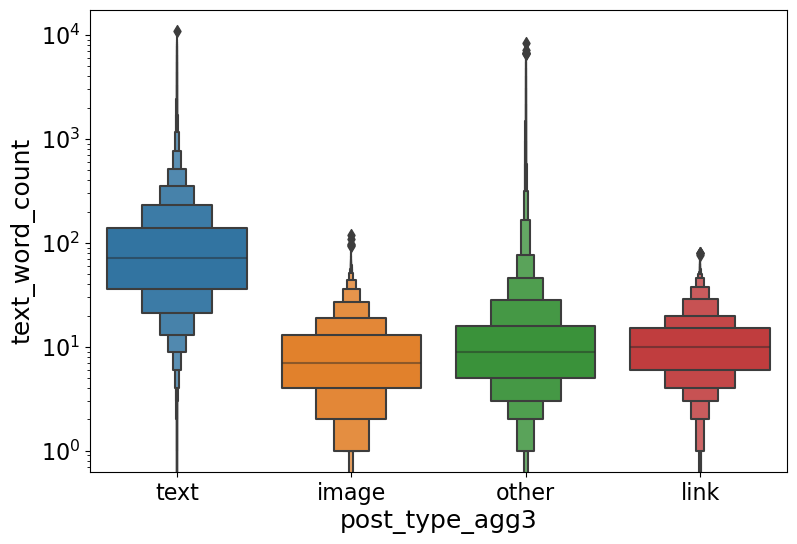

In [78]:
%%time

col_plot_groupby_ = 'post_type_agg3'

ax = sns.boxenplot(
    x=col_plot_groupby_, 
    y="text_word_count", 
    data=df_posts
)
ax.set(yscale="log")

In [67]:
style_df_numeric(
    df_posts
    .groupby('post_type_agg3')
    [['text_word_count']]
    .describe()
    .T
).set_caption(f"Word Count by post_type")

### By subreddit

In [ ]:
# df_posts.head()

In [69]:
df_posts_per_sub.shape

(19192, 4)

In [70]:
df_posts_per_sub.head()

,count,percent,cumulative_percent,posts_per_day_mean
subreddit_name,,,,
redditbay_official,1200,0.000142,0.000142,23.076923
bonehurtingjuice,1200,0.000142,0.000284,23.076923
teachers,1200,0.000142,0.000427,23.076923
tea,1200,0.000142,0.000569,23.076923
paranormal,1200,0.000142,0.000711,23.076923


In [71]:
df_post_len_sub = (
    df_posts[df_posts['subreddit_name'].isin(df_posts_per_sub.head(50).index)]
    .groupby(['subreddit_name', 'manual_topic_and_rating'])['text_len'].describe()
    .sort_values(by=['mean'], ascending=False)
)
style_df_numeric(
    df_post_len_sub.head(20)
).set_caption(f"Stats by Subreddit: Post Text Length (title + body)")

,,count,mean,std,min,25%,50%,75%,max
subreddit_name,manual_topic_and_rating,,,,,,,,
paranormal,uncategorized,"1,200","1,987.73","1,843.14",108.00,847.75,"1,403.50","2,557.75","22,115.00"
redditbay_official,uncategorized,"1,200","1,895.16","2,871.13",22.00,654.00,"1,105.00","1,720.25","18,734.00"
parenting,uncategorized,"1,200","1,209.36",954.62,100.00,601.75,980.00,"1,536.25","10,563.00"
pathfinder_rpg,uncategorized,"1,200","1,050.46","1,841.94",20.00,340.00,634.00,"1,043.00","35,521.00"
pathfinder2e,uncategorized,"1,200","1,047.82","1,872.10",10.00,165.75,502.50,"1,127.50","21,521.00"
enneagram,uncategorized,"1,200",947.96,"2,122.79",3.00,77.00,301.00,931.25,"28,475.00"
endo,uncategorized,"1,200",941.35,941.82,9.00,404.75,671.00,"1,175.00","14,677.00"
teachers,uncategorized,"1,200",904.37,881.68,41.00,380.75,660.50,"1,142.00","11,841.00"
enfp,uncategorized,"1,200",688.45,"1,468.38",2.00,134.00,360.50,769.50,"35,771.00"


In [76]:
style_df_numeric(
    df_post_len_sub[df_post_len_sub.index.get_level_values('manual_topic_and_rating') != 'over18_nsfw']
    .head(15)
).set_caption(f"Stats by Subreddit: Post Text Length (title + body) - Excluding NSFW")

,,count,mean,std,min,25%,50%,75%,max
subreddit_name,manual_topic_and_rating,,,,,,,,
paranormal,uncategorized,"1,200","1,987.73","1,843.14",108.00,847.75,"1,403.50","2,557.75","22,115.00"
redditbay_official,uncategorized,"1,200","1,895.16","2,871.13",22.00,654.00,"1,105.00","1,720.25","18,734.00"
parenting,uncategorized,"1,200","1,209.36",954.62,100.00,601.75,980.00,"1,536.25","10,563.00"
pathfinder_rpg,uncategorized,"1,200","1,050.46","1,841.94",20.00,340.00,634.00,"1,043.00","35,521.00"
pathfinder2e,uncategorized,"1,200","1,047.82","1,872.10",10.00,165.75,502.50,"1,127.50","21,521.00"
enneagram,uncategorized,"1,200",947.96,"2,122.79",3.00,77.00,301.00,931.25,"28,475.00"
endo,uncategorized,"1,200",941.35,941.82,9.00,404.75,671.00,"1,175.00","14,677.00"
teachers,uncategorized,"1,200",904.37,881.68,41.00,380.75,660.50,"1,142.00","11,841.00"
enfp,uncategorized,"1,200",688.45,"1,468.38",2.00,134.00,360.50,769.50,"35,771.00"


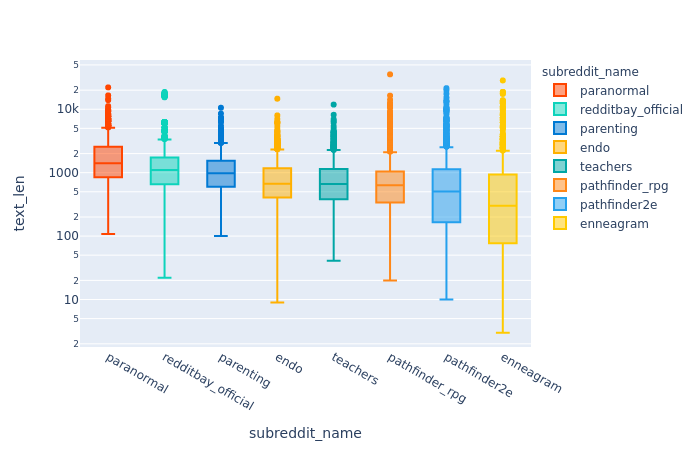

CPU times: user 532 ms, sys: 140 ms, total: 672 ms
Wall time: 1.73 s


In [73]:
%%time

# this plot loses meaning with "all" points, so let's try with only the outliers
n_subs = 8
# l_subs_with_most_posts = df_posts_per_sub.head(n_subs).index
l_subs_with_most_posts = (
    df_post_len_sub[df_post_len_sub.index.get_level_values('manual_topic_and_rating') != 'over18_nsfw']
    .head(n_subs)
    .index.get_level_values('subreddit_name')
)

l_subs_sorted_by_text_len = (
    df_post_len_sub
    [df_post_len_sub.index.get_level_values('subreddit_name').isin(l_subs_with_most_posts)]
    .sort_values(by='50%', ascending=False)
    .index.get_level_values('subreddit_name')
    .to_list()
)

col_plot_groupby_ = 'subreddit_name'
fig = px.box(
    df_posts[df_posts['subreddit_name'].isin(l_subs_with_most_posts)],
    x=col_plot_groupby_, 
    y="text_len",
    color=col_plot_groupby_,
    color_discrete_sequence=get_colormap(n_subs, return_as_list=True),
    category_orders={
        col_plot_groupby_: l_subs_sorted_by_text_len,
    },
    log_y=True,
)

# fig.update_traces(boxpoints='outliers', jitter=0.5)
# fig.show()

fig.show(renderer='png')

In [74]:
%%time
style_df_numeric(
    df_posts[df_posts['subreddit_name'].isin(df_posts_per_sub.head(20).index)]
    .groupby('subreddit_name')['text_word_count'].describe()
    .sort_values(by=['mean'], ascending=False)
).set_caption(f"Stats by Subreddit: Post Text Estimated Word Count (title + body)")

CPU times: user 317 ms, sys: 27.3 ms, total: 345 ms
Wall time: 331 ms


,count,mean,std,min,25%,50%,75%,max
subreddit_name,,,,,,,,
paranormal,"1,200",390.51,357.63,21.00,168.00,275.00,502.25,"4,143.00"
redditbay_official,"1,200",299.03,442.91,3.00,101.00,176.00,271.00,"2,870.00"
parenting,"1,200",239.61,187.08,15.00,119.00,196.00,308.00,"2,171.00"
pathfinder2e,"1,200",186.22,322.74,2.00,30.00,92.50,204.00,"3,610.00"
pathfinder_rpg,"1,200",185.75,315.50,3.00,62.00,115.00,187.25,"6,562.00"
teachers,"1,200",171.80,166.05,8.00,72.75,126.00,218.00,"2,214.00"
pathfinder_kingmaker,"1,200",120.18,318.42,1.00,9.00,34.50,109.00,"5,596.00"
pathofexile,"1,200",107.72,253.48,1.00,8.00,15.00,101.25,"3,319.00"
tea,"1,200",48.63,71.88,1.00,9.00,21.00,63.00,853.00


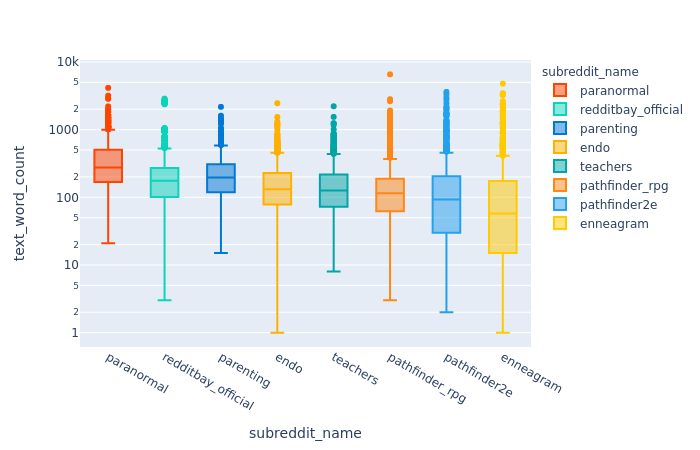

CPU times: user 428 ms, sys: 120 ms, total: 549 ms
Wall time: 2.2 s


In [75]:
%%time

# this plot loses meaning with "all" points, so let's try with only the outliers

col_plot_groupby_ = 'subreddit_name'
fig = px.box(
    df_posts[df_posts['subreddit_name'].isin(l_subs_with_most_posts)],
    x=col_plot_groupby_, 
    y="text_word_count",
    color=col_plot_groupby_,
    color_discrete_sequence=get_colormap(n_subs, return_as_list=True),
    category_orders={
        col_plot_groupby_: l_subs_sorted_by_text_len,
    },
    log_y=True,
)

# fig.update_traces(boxpoints='outliers', jitter=0.5)
# fig.show()
fig.show(renderer='png')

## What posting country is most common?

In [64]:
value_counts_and_pcts(
    df_posts,
    ['geolocation_country_code'],
    top_n=15
)

,count,percent,cumulative_percent
geolocation_country_code,,,
us,"4,205,071",49.8%,49.8%
gb,"574,111",6.8%,56.6%
ca,"526,207",6.2%,62.9%
in,"299,507",3.5%,66.4%
,"258,918",3.1%,69.5%
au,"245,775",2.9%,72.4%
de,"224,118",2.7%,75.0%
br,"140,524",1.7%,76.7%
ph,"136,182",1.6%,78.3%


# Detectected language stats

## Detected language in all posts, raw v. weighted

In [80]:
# already calculated in data loader
# df_posts['weighted_language_top'] = np.where(
#     df_posts['weighted_language'].isin(['en', 'de', ]),
#     df_posts['weighted_language'],
#     'other'
# )

value_counts_and_pcts(df_posts['weighted_language_top'])

,weighted_language_top-count,weighted_language_top-percent,weighted_language_top-pct_cumulative_sum
English,"7,297,230",86.5%,86.5%
Other language,"138,038",1.6%,88.1%
German,"135,996",1.6%,89.7%
Spanish,"90,288",1.1%,90.8%
Portuguese,"83,717",1.0%,91.8%
French,"54,513",0.6%,92.4%
Italian,"53,512",0.6%,93.1%
UNKNOWN,"47,593",0.6%,93.6%
Afrikaans,"44,132",0.5%,94.1%
Dutch,"42,053",0.5%,94.6%


In [81]:
style_df_numeric(    
    compare_raw_v_weighted_language(
        df_posts, col_lang_raw='language', col_lang_weighted='weighted_language',
        suffixes=('_raw', '_weighted'),
    ).head(15),
    l_bar_simple=['percent_weighted', 'count_diff']
).set_caption('Overall Detected Language')

,count_raw,percent_raw,cumulative_percent_raw,count_weighted,percent_weighted,count_diff,percent_diff
en,"7,249,674",85.90%,85.90%,"7,297,230",86.46%,"47,556",0.56%
de,"141,091",1.67%,87.57%,"135,996",1.61%,"-5,095",-0.06%
es,"89,344",1.06%,88.63%,"90,288",1.07%,944,0.01%
pt,"83,613",0.99%,89.62%,"83,717",0.99%,104,0.00%
fr,"58,735",0.70%,90.32%,"54,513",0.65%,"-4,222",-0.05%
it,"55,047",0.65%,90.97%,"53,512",0.63%,"-1,535",-0.02%
af,"48,245",0.57%,91.54%,"44,132",0.52%,"-4,113",-0.05%
UNKNOWN,"47,593",0.56%,92.10%,"47,593",0.56%,0,0.00%
nl,"44,334",0.53%,92.63%,"42,053",0.50%,"-2,281",-0.03%
no,"40,204",0.48%,93.11%,"37,185",0.44%,"-3,019",-0.04%


## For each sub, what's the proportion of detected language?

In [93]:
# we have too many languages for this wide table to be useful
#. Instead check the predomininan-language column in df_sub_meta
# style_df_numeric(
#     get_language_by_sub_wide(
#         df_posts,
#         col_sub_name='subreddit_name',
#         col_lang_weighted='weighted_language_top',
#         col_total_posts='total_posts_count',
#     ).head(20),
# #     l_bar_simple=['total_posts_count', 'de_percent'],
# )

In [104]:
l_language_pct_cols = [c for c in df_sub_meta.columns if c.endswith('posts_percent')]
l_post_type_pct_cols = [c for c in df_sub_meta.columns if (c.endswith('post_type_percent') & ~(c.startswith('primary_')))]

In [107]:

style_df_numeric(
    df_sub_meta
    .query("geo_relevant_subreddit == True & posts_l28 >= 10")
    [reorder_array(['primary_post_language', 'primary_post_language_percent', 'subreddit_title',
                    'primary_post_type', 'primary_post_type_percent', 'posts_for_modeling_count'], 
                   df_sub_meta.drop(l_language_pct_cols + l_post_type_pct_cols, axis=1).columns)
    ]
    .drop(['subreddit_description', 'subreddit_public_description', 'subreddit_name_title_and_clean_descriptions', 'pt_date', 'pt'], axis=1)
    .head(10)
    ,
    rename_cols_for_display=True,
)

,primary post language,primary post language percent,subreddit title,primary post type,primary post type percent,posts for modeling count,subreddit name,subreddit id,geo relevant country codes,geo relevant countries,geo relevant country count,geo relevant subreddit,ambassador subreddit,combined topic,combined topic and rating,rating short,rating name,primary topic,secondary topics,mature themes list,over 18,allow top,video whitelisted,subreddit language,whitelist status,subscribers,first screenview date,last screenview date,users l7,users l28,posts l7,posts l28,comments l7,comments l28,subreddit clean description word count,subreddit name title and clean descriptions word count,manual topic and rating,primary post language in use multilingual,post median word count
102,English,100.00%,Ask the United Kingdom,text,100.00%,"1,200",askuk,t5_2t4s3,GB,United Kingdom,1,True,False,uncategorized,uncategorized,E,Everyone,Place,,,None,t,None,en,all_ads,"432,908",2020-08-24,2021-09-21,"835,901","2,986,157","1,290","4,983","52,161","221,235",271,294,uncategorized,True,72
103,English,95.75%,CasualUK,image,65.25%,"1,200",casualuk,t5_3j2jr,GB,United Kingdom,1,True,False,uncategorized,uncategorized,E,Everyone,None,,,None,t,None,en,all_ads,"873,631",2020-08-24,2021-09-21,"1,294,522","2,980,349","1,093","4,261","38,245","142,334",367,379,uncategorized,True,11
126,English,89.42%,The back page of the internet,link,86.58%,"1,200",soccer,t5_2qi58,GB,United Kingdom,1,True,False,uncategorized,uncategorized,E,Everyone,Sports,,,f,f,None,en,all_ads,"2,952,511",2020-08-24,2021-09-21,"955,087","2,501,319","2,723","14,362","212,484","988,081",500,518,uncategorized,True,20
161,English,96.50%,Canada,link,99.67%,"1,200",canada,t5_2qh68,CA,Canada,1,True,False,uncategorized,uncategorized,E,Everyone,Place,,,f,t,f,en,all_ads,"1,029,580",2020-08-24,2021-09-21,"950,001","2,043,870","1,629","6,051","105,000","354,323",873,953,uncategorized,True,13
174,English,98.58%,Australia,link,86.00%,"1,200",australia,t5_2qh8e,AU,Australia,1,True,False,uncategorized,uncategorized,E,Everyone,Place,,"profanity_occasional, profanity",f,t,f,en,all_ads,"740,915",2020-08-24,2021-09-21,"630,223","1,948,151","1,422","5,737","43,419","171,935",194,212,uncategorized,True,13
187,English,95.92%,/r/Ontario,link,49.25%,"1,200",ontario,t5_2qsf3,CA,Canada,1,True,False,uncategorized,uncategorized,E,Everyone,Place,,,f,t,f,en,all_ads,"353,790",2020-08-24,2021-09-21,"596,059","1,747,033",793,"3,271","41,861","167,588",489,548,uncategorized,True,14
204,English,99.83%,British Problems,text,100.00%,"1,200",britishproblems,t5_2sumw,GB,United Kingdom,1,True,False,uncategorized,uncategorized,E,Everyone,Funny/Humor,,"profanity_occasional, profanity",None,t,None,en,all_ads,"676,357",2020-08-24,2021-09-21,"773,558","1,650,464",910,"3,652","27,531","104,436",445,457,uncategorized,True,34
224,German,96.92%,r/de – Extraordinär gut!,link,37.75%,"1,200",de,t5_22i0,DE,Germany,1,True,False,uncategorized,uncategorized,E,Everyone,Place,,,f,t,f,de,all_ads,"492,356",2020-08-24,2021-09-21,"570,140","1,515,454","1,827","6,893","74,253","288,987",387,418,place/culture,True,12
241,English,78.75%,KSI,image,65.58%,"1,200",ksi,t5_2xd5g,GB,United Kingdom,1,True,False,uncategorized,uncategorized,E,Everyone,Funny/Humor,,,None,t,None,en,some_ads,"2,268,649",2020-08-24,2021-09-21,"428,759","1,435,566","4,089","28,151","19,984","133,269",9,15,uncategorized,True,6
261,English,99.25%,United Kingdom,link,95.50%,"1,200",unitedkingdom,t5_2qhqb,GB,United Kingdom,1,True,False,uncategorized,uncategorized,E,Everyone,Place,,,f,t,f,en,all_ads,"614,086",2020-08-24,2021-09-21,"466,239","1,325,581","1,204","4,338","37,689","139,944",260,288,uncategorized,True,12


In [113]:

style_df_numeric(
    df_sub_meta
    .query("geo_relevant_subreddit == True & posts_l28 >= 10")
    [reorder_array(['primary_post_language', 'primary_post_language_percent', 'subreddit_title',
                    'primary_post_type', 'primary_post_type_percent', 'posts_for_modeling_count'], 
                   df_sub_meta.drop(l_language_pct_cols + l_post_type_pct_cols, axis=1).columns)
    ]
    .drop(['subreddit_description', 'subreddit_public_description', 'subreddit_name_title_and_clean_descriptions', 'pt_date', 'pt'], axis=1)
    .tail(10)
    ,
    rename_cols_for_display=False,
)

,primary_post_language,primary_post_language_percent,subreddit_title,primary_post_type,primary_post_type_percent,posts_for_modeling_count,subreddit_name,subreddit_id,geo_relevant_country_codes,geo_relevant_countries,geo_relevant_country_count,geo_relevant_subreddit,ambassador_subreddit,combined_topic,combined_topic_and_rating,rating_short,rating_name,primary_topic,secondary_topics,mature_themes_list,over_18,allow_top,video_whitelisted,subreddit_language,whitelist_status,subscribers,first_screenview_date,last_screenview_date,users_l7,users_l28,posts_l7,posts_l28,comments_l7,comments_l28,subreddit_clean_description_word_count,subreddit_name_title_and_clean_descriptions_word_count,manual_topic_and_rating,primary_post_language_in_use_multilingual,post_median_word_count
19193,English,84.62%,Burgsysadherents,image,61.54%,13,burgsysadherents,t5_51u3ik,BR,Brazil,1,True,False,uncategorized,uncategorized,None,None,None,None,None,None,t,None,en,None,1,2021-09-16,2021-09-21,44,44,14,14,0,0,0,11,uncategorized,True,5
19194,Spanish,100.00%,Estado Libre y Soberano de Aguascalientes,link,81.82%,11,aguascalientesmx,t5_52et5h,MX,Mexico,1,True,False,uncategorized,uncategorized,None,None,None,None,None,None,t,None,es,None,7,2021-09-20,2021-09-21,42,42,11,11,2,2,18,43,uncategorized,True,9
19195,Swahili,25.00%,SouthIndianGirls,image,70.00%,20,southindiangirls,t5_52fqtg,IN,India,1,True,False,uncategorized,uncategorized,None,None,None,None,None,None,t,None,en,None,6,2021-09-20,2021-09-21,42,42,15,15,0,0,0,2,uncategorized,False,2
19196,English,80.00%,AntisenseTherapeutics,text,70.00%,10,antisensetherapeutics,t5_50wjrp,DE,Germany,1,True,False,uncategorized,uncategorized,None,None,None,None,None,None,t,None,en,None,2,2021-09-10,2021-09-21,33,40,4,10,0,0,0,67,uncategorized,True,38
19197,English,63.64%,criptoportugal,crosspost,45.45%,11,criptoportugal,t5_50hito,PT,Portugal,1,True,False,uncategorized,uncategorized,None,None,None,,,None,t,None,en,None,2,2021-09-08,2021-09-21,38,39,11,12,25,25,0,31,uncategorized,True,15
19201,English,88.24%,ShittyShitcoinsNFT,image,47.06%,17,shittyshitcoinsnft,t5_51d131,ES,Spain,1,True,False,uncategorized,uncategorized,None,None,None,,,None,t,None,en-us,None,4,2021-09-13,2021-09-21,34,36,4,15,0,3,0,36,uncategorized,True,10
19203,English,38.10%,Sport_candy,image,71.43%,21,sport_candy,t5_51twc4,IN,India,1,True,False,uncategorized,uncategorized,None,None,None,None,None,None,t,None,en,None,1,2021-09-16,2021-09-21,35,35,18,18,0,0,0,2,uncategorized,True,2
19207,German,60.00%,gangelias,image,60.00%,10,gangelias,t5_51y9yj,DE,Germany,1,True,False,uncategorized,uncategorized,None,None,None,,,None,t,None,en,None,6,2021-09-17,2021-09-21,34,34,10,10,8,8,0,3,uncategorized,True,4
19208,English,57.89%,indiaisgreatnews,text,52.63%,19,indiaisgreatnews,t5_51swhj,IN,India,1,True,False,uncategorized,uncategorized,None,None,None,,,f,t,None,en,None,1,2021-09-16,2021-09-21,34,34,27,27,4,4,0,27,uncategorized,True,11
19212,Portuguese,61.11%,NOSSO CANAL,image,75.93%,54,artficer,t5_526cq6,BR,Brazil,1,True,False,uncategorized,uncategorized,None,None,None,None,None,None,t,None,pt,None,11,2021-09-19,2021-09-21,32,32,69,69,17,17,0,11,uncategorized,True,4


In [110]:
# df_lang_by_sub = get_language_by_sub_long(
#     df_posts,
#     col_sub_name='subreddit_name',
#     col_lang_weighted='weighted_language_top',
#     col_total_posts='total_posts_count',
# )

# # stack for inspection
# style_df_numeric(
#     df_lang_by_sub
#     .set_index(['subreddit_name', 'weighted_language_top'])[['count', 'percent']]
#     .head(12)
# )

In [112]:
# style_df_numeric(
#     df_lang_by_sub.groupby('weighted_language_top')['percent'].describe(),
#     float_round=4, pct_labels=['mean', 'std', 'min', 'max', '%']
# ).set_caption(f"Distribution of Language by Subreddit")

In [116]:
style_df_numeric(
    (
        df_sub_meta.groupby('primary_post_language')['primary_post_language_percent']
        .describe()
        .sort_values(by=['count'], ascending=False)
    ),
    float_round=4, pct_labels=['mean', 'std', 'min', 'max', '%'],
    l_bar_simple=['50%', 'mean', 'count']
).set_caption(f"Distribution of Primary Language by Subreddit")

,count,mean,std,min,25%,50%,75%,max
primary_post_language,,,,,,,,
English,"16,902",89.89%,13.07%,11.92%,86.96%,94.52%,98.32%,100.00%
German,596,78.64%,19.47%,24.10%,66.67%,84.62%,95.41%,100.00%
Spanish,545,65.61%,24.06%,15.62%,44.44%,66.67%,88.76%,100.00%
Portuguese,337,78.35%,19.91%,24.00%,64.89%,83.47%,96.00%,100.00%
French,159,78.66%,20.00%,28.26%,65.27%,83.78%,96.99%,100.00%
Italian,156,77.55%,18.29%,13.95%,69.39%,78.63%,92.14%,100.00%
UNKNOWN,153,53.97%,19.67%,23.70%,38.18%,52.17%,63.33%,100.00%
Other language,107,51.41%,25.73%,13.81%,26.04%,50.00%,73.90%,100.00%
Dutch,28,68.67%,21.70%,33.33%,49.42%,75.43%,87.30%,100.00%


In [117]:
# fig = px.box(
#     df_lang_by_sub,
#     x="weighted_language_top", y="percent", color='weighted_language_top',
#     color_discrete_sequence=get_colormap(4, return_as_list=True),
#     category_orders={
#         'weighted_language_top': ['de', 'en', 'other']
#     },
#     points="all"
# )
# # fig.show()
# fig.show(renderer='png')

In [118]:
# # TODO(djb) update for primary language instead of de, en, & other

# fig = px.bar(
#     df_lang_by_sub[df_lang_by_sub['weighted_language_top'] != 'UNKNOWN'].head(36),

#     x='subreddit_name',
#     y='percent',
#     color='weighted_language_top', barmode='group',
#     text='percent',
#     height=500,
#     width=900,
#     color_discrete_sequence=get_colormap(4, return_as_list=True),
#     category_orders={
#         'weighted_language_top': ['de', 'en', 'other']
#     },
# )

# fig.update_traces(
#     texttemplate='%{text:.0%}',
#     textposition='outside'
# )
# fig.update_layout(uniformtext_minsize=6.9, uniformtext_mode='show')

# # fig.show()
# fig.show(renderer='png')

# Check repeated text - ~32% of text is not unique

In v0.3.2 most duplicates used to come from `ich_iel`, which makes sense given that people post memes/photos. Duplicates were also common in NSFW subs (`nicole*`, `elisa*`, `sonnyloops`).

For v0.4.0 we see a similar pattern -- meme communities like `nocontextpics` and `hmmm` have all or almost all of their posts share the same text.

In [119]:
mask_text_dupes = df_posts.duplicated(subset=['text'], keep=False)

print(f"{mask_text_dupes.sum() / len(df_posts):,.2%} percent of posts have at least one duplicate")

value_counts_and_pcts(
    df_posts[mask_text_dupes],
    ['subreddit_name']
)

9.70% percent of posts have at least one duplicate


,count,percent,cumulative_percent
subreddit_name,,,
nocontextpics,"1,200",0.1%,0.1%
hmmm,"1,200",0.1%,0.3%
11hr11min,"1,199",0.1%,0.4%
anime_irl,"1,198",0.1%,0.6%
maybemaybemaybe,"1,198",0.1%,0.7%
commentremovalchecker,"1,194",0.1%,0.9%
blurrypicturesofcats,"1,183",0.1%,1.0%
me_irl,"1,182",0.1%,1.2%
meirl,"1,173",0.1%,1.3%


## Most of the dupes come from `ich_iel`
The dupe is some version of `ich iel`

In [120]:
value_counts_and_pcts(
    df_posts[mask_text_dupes],
    ['text', 'subreddit_name'],
    cumsum=False,
)

,,count,percent
text,subreddit_name,,
PIC,nocontextpics,"1,200",0.1%
hmmm,hmmm,"1,200",0.1%
💗☁🍦🌸🧁🤍🦩,11hr11min,"1,199",0.1%
2meirl4meirl,2meirl4meirl,"1,133",0.1%
discord_irl,discord_irl,981,0.1%
hmmm,minecrafthmmm,888,0.1%
anime_irl,anime_irl,857,0.1%
me_irl,me_irl,723,0.1%
Maybe Maybe Maybe,maybemaybemaybe,691,0.1%


### This time, though, we have OCR and flair!

So even if the text is the same, we can **hopefully** get something more meaningful than before by using other text sources

In [121]:
l_text_cols = [c for c in df_posts.columns if 'text' in c]
l_text_cols

['flair_text',
 'text_len',
 'ocr_text_len',
 'text_word_count',
 'ocr_text_word_count',
 'text',
 'ocr_inferred_text_agg_clean']

In [123]:
(
    df_posts[mask_text_dupes]
    .query("ocr_text_len >= 1")
).shape

(209569, 51)

In [127]:
f"{209569 / mask_text_dupes.sum():,.1%} <-Duplicates that have OCR text"

'25.6% <-Duplicates that have OCR text'

In [145]:
style_df_numeric(
    df_posts[mask_text_dupes]
    .query("ocr_text_len >= 1 & ocr_text_len <= 180")
    [reorder_array(l_text_cols + ['post_url_for_embeddings'], 
                   df_posts.columns)
    ]
    # .drop(['subreddit_description', 'subreddit_public_description', 'subreddit_name_title_and_clean_descriptions', 'pt_date', 'pt'], axis=1)
    .sort_values(by=['text', 'subreddit_name',])
    .iloc[:10, :28]
    ,
    rename_cols_for_display=True,
).hide_index()

flair text,text len,ocr text len,text word count,ocr text word count,text,ocr inferred text agg clean,post url for embeddings,rank post in sub,subreddit name,subreddit id,post id,user id,thing type,submit date,removed,upvotes,upvotes lookup,downvotes lookup,net upvotes lookup,neutered,verdict,content category,comments,successful,app name,post type,post nsfw
None,2,49.00,0,9,!,CERRRI LUJ FRI FAJER: ALKINGZ: IGHT IMMA HEAD OUT,None,43,alkingz,t5_4ojga7,t3_p3rywm,t2_8h75y922,post,2021-08-13 00:00:00,0,1,4,0,4,False,None,None,0,0,web2x,image,False
None,2,39.00,0,6,!,When someone calls instead of messaging,None,18,avpd,t5_2vjua,t3_pchhia,t2_d706jasp,post,2021-08-27 00:00:00,0,123,141,0,141,False,None,None,8,1,android,image,False
None,2,22.00,0,5,!,AUNG HITA FINE ART COM,None,29,blouselesssaree,t5_4tjgrk,t3_p9x2i7,t2_6qaytklx,post,2021-08-23 00:00:00,0,15,33,0,33,False,None,None,0,0,android,image,False
None,2,52.00,0,7,!,DIE TALIBAN EROBERN REDDIT SCHNELLER ALS AFGHANISTAN,None,14,deutschememes,t5_3hn0l,t3_p5lfg9,t2_61efkkcq,post,2021-08-16 00:00:00,0,108,151,4,147,False,None,None,3,1,android,image,False
None,2,27.00,0,3,!,LATERIT TSCHERNOSEM imgflip,None,374,geology,t5_2qshr,t3_pkgjdx,t2_cyv4ln7x,post,2021-09-08 00:00:00,0,4,7,2,5,False,mod-approved,None,0,0,web2x,image,False
None,2,60.00,0,11,!,Why does her breath.. Smell like my homies dick? SNIFF SNIFF,None,157,holdup,t5_qt1cv,t3_piur1b,t2_dcqwfwzc,post,2021-09-06 00:00:00,0,132,191,1,190,False,None,None,4,1,web2x,image,False
None,2,97.00,0,17,!,THE SECOND EMENDMENT Constitution for kids edtion shall not be infringed ATF I wish I could read.,None,"1,074",libertarianmeme,t5_2te5l,t3_p3oii4,t2_bo414a3p,post,2021-08-13 00:00:00,0,106,173,3,170,False,None,None,5,1,ios,image,False
None,2,29.00,0,6,!,NET WT. g Mang CHICKEN OIL МЕ,None,"1,075",nanikposting,t5_2vw7vv,t3_p25ivv,t2_9136sf4b,post,2021-08-11 00:00:00,0,73,87,2,85,False,None,None,6,1,web2x,image,False
spaß mit minjens:minjen:,2,49.00,0,7,!,MIKE FOTZKOPFSKI MIKE FOTZKOPSKI ade with mematic,None,262,okbrudimongo,t5_ofkj1,t3_ppwbho,t2_3otxhy48,post,2021-09-17 00:00:00,0,99,102,3,99,False,None,None,0,0,android,image,False
Report,2,86.00,0,15,!,Just found out the company that produces yardsticks won't be making them any longer. (,None,61,punpatrol,t5_q4neh,t3_p4vh7j,t2_qt39dtb,post,2021-08-15 00:00:00,0,367,437,1,436,False,None,None,5,1,ios,image,False


In [146]:
style_df_numeric(
    df_posts[mask_text_dupes]
    .query("ocr_text_len >= 1 & ocr_text_len <= 180")
    [reorder_array(l_text_cols + ['post_url_for_embeddings'], 
                   df_posts.columns)
    ]
    # .drop(['subreddit_description', 'subreddit_public_description', 'subreddit_name_title_and_clean_descriptions', 'pt_date', 'pt'], axis=1)
    .sort_values(by=['text', 'subreddit_name',])
    .iloc[-10:, :28]
    ,
    rename_cols_for_display=True,
).hide_index()

flair text,text len,ocr text len,text word count,ocr text word count,text,ocr inferred text agg clean,post url for embeddings,rank post in sub,subreddit name,subreddit id,post id,user id,thing type,submit date,removed,upvotes,upvotes lookup,downvotes lookup,net upvotes lookup,neutered,verdict,content category,comments,successful,app name,post type,post nsfw
None,263,179.00,40,29,"🪂 CoinxPad FIRST airdrop 🪂CXPAD is the pioneer in the centralized/decentralized Multi-Chain #IDO Launchpad. ⏰ 1 MIN Application Process Alarm clock 🚨 Airdrop Reward: Up to 313,000 CXPAD [~$5] 🚨 Referral Reward: 61 Million CXPAD [~$976] for the top 100 referrers.","CoinxPad AIRDROP ALERT! , CXPAD TOKEN WATCH OUT AS LUCKY WINNERS WILL BE PICKED FROM ALL ELIGIBLE PARTICIPANTS! PRESALE on Unicrypt on SEPT to ! O coinxpad.io O twitter/coinxpad",None,102,cryptoairdrop,t5_3pw7w,t3_pqaqew,t2_czrqor80,post,2021-09-17 00:00:00,0,1,2,0,2,False,None,None,0,0,web2x,image,False
None,27,107.00,5,19,🪐50% discount only 7 days!,AE Watch Faces % OFF pm Aug Fri Avolobie on SE SAMSUNG Galaxy Store t.me/ae_wf facebook/groups/aewatch,None,207,galaxygear,t5_2y87g,t3_piyrxk,t2_bwl0hmu2,post,2021-09-06 00:00:00,0,0,1,0,1,False,None,None,1,0,web2x,image,False
Discount - Digital,27,107.00,5,19,🪐50% discount only 7 days!,AE Watch Faces % OFF pm Aug Fri Avolobie on SE SAMSUNG Galaxy Store t.me/ae_wf facebook/groups/aewatch,None,701,galaxywatchface,t5_25ka5g,t3_piys4v,t2_bwl0hmu2,post,2021-09-06 00:00:00,0,1,2,1,1,False,None,None,0,0,web2x,image,False
None,2,19.00,0,4,🪙,OH LOOK A PENNY“ רר,None,69,motogp,t5_2r7pg,t3_pcprtm,t2_8ojdp5jx,post,2021-08-27 00:00:00,0,462,748,42,706,False,None,None,21,1,ios,image,False
Aktienvorschlag,2,15.00,0,2,🪙,口 SEIT START €,None,38,wallstreetbetsger,t5_4kmgkj,t3_oxnb8o,t2_a1vona2q,post,2021-08-04 00:00:00,0,6,6,4,2,False,None,None,7,1,android,image,False
:KEKW:MEMES,2,171.00,0,34,🪨,No me juzgues por ser cocalover Coca-Cola Coke wwwQ CocaCola Coca-Cola Delicius and Rel nací por y moriré por Piedras en los riñones mi madre Coca-Cola Coca-Cola Coca-Cola,None,55,streaminghousecl,t5_2syi1r,t3_pj2o2c,t2_7mfygsd7,post,2021-09-06 00:00:00,0,3,7,0,7,False,None,None,0,0,android,image,False
None,5,176.00,0,32,🪨📃✂️,O Imaonade Follow if you're playing rock paper scissors and you do the same attack you have to kiss fireball-me Follow rock-rock: kiss paper-paper: high five scissors-scissors:,None,398,suddenlygay,t5_35f67,t3_p1490w,t2_daruy998,post,2021-08-09 00:00:00,0,371,682,2,680,False,None,None,7,1,ios,image,False
Image,2,32.00,0,7,🪱,DOWN WITA NONTS Alo el onu CAMRY,None,60,leftwithoutedge,t5_3bgym,t3_pby3zp,t2_e0b2h,post,2021-08-26 00:00:00,0,115,110,7,103,False,None,None,14,1,ios,image,False
None,2,160.00,0,31,🪲,All that struggle in the path of pain and I get nothing A journal entry AND a minimalist cutscene that shows how the infection came to be? That's pretty awesome,None,200,hollowknightmemes,t5_j958e,t3_pkx4l5,t2_mpzqws,post,2021-09-09 00:00:00,0,"1,701","2,164",4,"2,160",False,None,None,26,1,web2x,image,False
None,2,3.00,0,1,🫐,DRA,None,36,lorrainesd,t5_23bz44,t3_proxpr,t2_16nrc0,post,2021-09-20 00:00:00,0,175,227,1,226,False,None,None,5,1,ios,gallery,unlabeled


In [ ]:
TODO

## After we exclude `ich_iel` and some NSFW subreddits we still have some dupes but now it's still ~29%

In [143]:
mask_no_iel = ~(df_posts['subreddit_name'].isin(['ich_iel']))
mask_no_iel_and_some_nsfw = ~(df_posts['subreddit_name'].isin(['ich_iel', 'katjakrasavicenudes']))

count_dupes_no_iel = df_posts[mask_no_iel].duplicated(subset=['text'], keep=False).sum()

print(f"Dupes when excluding `ich_iel`: {count_dupes_no_iel:,.0f}\n"
      f"{count_dupes_no_iel / len(df_posts[mask_no_iel]):,.2%} "
      f"percent of posts have at least one duplicate"
     )

Dupes when excluding `ich_iel`: 818,068
9.69% percent of posts have at least one duplicate


In [68]:
value_counts_and_pcts(
    df_posts[mask_text_dupes & mask_no_iel],
    ['text'], top_n=10
)

,count,percent,cumulative_percent
text,,,
Join the CELEBHOUSE Discord Server!,443,0.5%,0.5%
.,400,0.5%,1.0%
Gönnt euch,255,0.3%,1.3%
Join,229,0.3%,1.5%
Suche jemanden der W im rp spielt dm,198,0.2%,1.8%
Join the HannahOwO | NSFW Discord Server!,192,0.2%,2.0%
Nudes,182,0.2%,2.2%
NEUES VIDEO!!!->,180,0.2%,2.4%
Join the GermanFuck Discord Server!,179,0.2%,2.6%


### Dupes by other subreddits

In [69]:
value_counts_and_pcts(
    df_posts[mask_text_dupes &
             ~(df_posts['subreddit_name'].isin(['ich_iel', 'nicoledobrikovof']))
             ],
    ['text', 'subreddit_name'], top_n=10
)

,,count,percent,cumulative_percent
text,subreddit_name,,,
Join the Lia | NSFW Discord Server!,katjakrasavicenudes,116,0.1%,0.1%
Join the CELEBHOUSE Discord Server!,katjakrasavicenudes,115,0.1%,0.3%
Join,katjakrasavicenudes,102,0.1%,0.4%
Join the CELEBHOUSE Discord Server!,germanonlyfans,98,0.1%,0.5%
"Kann jemand eine ausführliche Sex Story zwischen einer Freundin von mir und mir schreiben während ich Bilder (keine Nudes) von ihr schicke? DM für Kik, Wickr oder Dis cord",wixbros,87,0.1%,0.6%
Join the HannahOwO | NSFW Discord Server!,katjakrasavicenudes,87,0.1%,0.7%
Jemand Lust in einem rp w für mich zu spielen Kik: Lhboring69,wixbros,66,0.1%,0.8%
Join the GermanFuck Discord Server!,katjakrasavicenudes,63,0.1%,0.9%
Nudes,katjakrasavicenudes,62,0.1%,1.0%


## Only after removing some `ich_iel` and some NSFW subs we see fewer than 15% of dupes

In [70]:
mask_no_iel_and_some_nsfw = ~(
    df_posts['subreddit_name']
    .isin(['ich_iel', 'katjakrasavicenudes',
           'wixbros', 'elisaalinenudes',
           'nicoledobrikov1', 'nicoledobrikovofs',
           'nicoledobrikovof', 'germanonlyfans',
           'germannudes', 'loredana',
           'deutschetributes', 'julesboringlifehot',
           'germancelebs', 'emmyruss',
           ])
)

count_dupes_no_iel_nsfw = df_posts[mask_no_iel_and_some_nsfw].duplicated(subset=['text'], keep=False).sum()

print(f"Dupes when excluding `ich_iel` & some NSFW subs: {count_dupes_no_iel_nsfw:,.0f}\n"
      f"{count_dupes_no_iel_nsfw / len(df_posts[mask_no_iel_and_some_nsfw]):,.2%} "
      f"percent of posts have at least one duplicate"
     )

Dupes when excluding `ich_iel` & some NSFW subs: 48,781
29.00% percent of posts have at least one duplicate


In [142]:
value_counts_and_pcts(
    df_posts[mask_text_dupes & mask_no_iel_and_some_nsfw],
    ['text', 'subreddit_name'], top_n=10
)

NameError: name 'mask_no_iel_and_some_nsfw' is not defined

In [141]:
for sub_ in ['nicoledobrikovof', 'de', 'germany']:
    display(
        value_counts_and_pcts(
            df_posts[mask_text_dupes & (df_posts['subreddit_name'] == sub_)],
            ['text', 'subreddit_name'], top_n=5
        )
    )
del sub_

,,count,percent,cumulative_percent
text,subreddit_name,,,


,,count,percent,cumulative_percent
text,subreddit_name,,,
"""Füllt eure Gefrierschränke"": Ungeimpfte preisen Sperma als ""neuen Bitcoin""",de,1,0.7%,0.7%
Schlafwagen statt Billigflieger: Die Grünen wollen Kurzstreckenflüge mit einem europäischen Nachtzugnetz überflüssig machen.,de,1,0.7%,1.4%
München iel,de,1,0.7%,2.0%
Nach Flutkatastrophe: Staatsanwaltschaft Koblenz ermittelt gegen Landrat von Ahrweiler,de,1,0.7%,2.7%
Neuer Uno-Weltklimabericht: Kritische Schwelle der Erderwärmung könnte schon 2030 gerissen werden,de,1,0.7%,3.4%


,,count,percent,cumulative_percent
text,subreddit_name,,,
Germany complains to Moscow over pre-election phishing attacks on politicians,germany,2,2.8%,2.8%
3D relief of Germany,germany,1,1.4%,4.2%
Meow meow (3 photos from street art in Hamburg and Berlin),germany,1,1.4%,5.6%
"Sprakebüll: A German village has successfully completed the energy transition: 100% renewable electricity from wind, solar and hydrogen. Produces 50x more electricity than the town uses and all heating is by biogas.",germany,1,1.4%,6.9%
Shitpost,germany,1,1.4%,8.3%


# About 45% of subreddits in this analysis are uncategorized or unrated

In [137]:
df_post_count_by_sub_and_rating = value_counts_and_pcts(
    df_posts,
    ['subreddit_name', 'combined_topic_and_rating'],
    top_n=None,
    return_df=True,
    reset_index=True,
)

value_counts_and_pcts(df_post_count_by_sub_and_rating['combined_topic_and_rating'])

,combined_topic_and_rating-count,combined_topic_and_rating-percent,combined_topic_and_rating-pct_cumulative_sum
uncategorized,"16,596",86.5%,86.5%
over18_nsfw,464,2.4%,88.9%
gaming,367,1.9%,90.8%
technology,170,0.9%,91.7%
internet culture and memes,134,0.7%,92.4%
place,124,0.6%,93.0%
television,106,0.6%,93.6%
podcasts and streamers,101,0.5%,94.1%
music,85,0.4%,94.6%
anime,67,0.3%,94.9%


## Posts in the uncategorized subs make up around 20% of posts in analysis


In [138]:
value_counts_and_pcts(
    df_posts,
    ['combined_topic_and_rating'],
    top_n=None,
    reset_index=True,
).set_caption(f"Count of posts by previous subreddit category")

,combined_topic_and_rating,count,percent,cumulative_percent
0,uncategorized,"7,552,643",89.5%,89.5%
1,over18_nsfw,"215,772",2.6%,92.0%
2,gaming,"150,686",1.8%,93.8%
3,podcasts and streamers,"50,284",0.6%,94.4%
4,internet culture and memes,"41,330",0.5%,94.9%
5,technology,"38,357",0.5%,95.4%
6,place,"35,499",0.4%,95.8%
7,medical and mental health,"26,631",0.3%,96.1%
8,music,"22,714",0.3%,96.4%
9,television,"22,249",0.3%,96.6%


### Looks like more NSFW subreddits have been labeled as nsfw/over 18 since last time I ran the analysis

In [139]:
style_df_numeric(df_post_count_by_sub_and_rating.head(20))

,subreddit_name,combined_topic_and_rating,count,percent,cumulative_percent
0,redditbay_official,uncategorized,"1,200",0.01%,0.01%
1,bonehurtingjuice,uncategorized,"1,200",0.01%,0.03%
2,teachers,uncategorized,"1,200",0.01%,0.04%
3,tea,uncategorized,"1,200",0.01%,0.06%
4,paranormal,uncategorized,"1,200",0.01%,0.07%
5,tds_roblox,uncategorized,"1,200",0.01%,0.09%
6,ender3,uncategorized,"1,200",0.01%,0.10%
7,pareidolia,uncategorized,"1,200",0.01%,0.11%
8,parenting,uncategorized,"1,200",0.01%,0.13%
9,parlerwatch,uncategorized,"1,200",0.01%,0.14%


In [140]:
style_df_numeric(
    df_post_count_by_sub_and_rating[df_post_count_by_sub_and_rating['combined_topic_and_rating'] == 'over18_nsfw'].head(20)
)

,subreddit_name,combined_topic_and_rating,count,percent,cumulative_percent
24,tau40k,over18_nsfw,"1,200",0.01%,0.36%
31,entexchange,over18_nsfw,"1,200",0.01%,0.45%
62,bollywoodmilfs,over18_nsfw,"1,200",0.01%,0.90%
67,periods,over18_nsfw,"1,200",0.01%,0.97%
72,persona,over18_nsfw,"1,200",0.01%,1.04%
111,evangelion,over18_nsfw,"1,200",0.01%,1.59%
211,supermodelindia,over18_nsfw,"1,200",0.01%,3.01%
246,pka,over18_nsfw,"1,200",0.01%,3.51%
267,subsimulatorgpt2,over18_nsfw,"1,200",0.01%,3.81%
278,dragonmaid,over18_nsfw,"1,200",0.01%,3.97%
